# Programming Homework 1

---

### Group 04

**Brian Huynh** (476188)  
**Paula Winter** (409827)  
**Paul Budden** (484284)  
**Anar Alizade** (477200)

---



## Table of Contents

**I. [Coding Implementation](#I)**  
&nbsp;&nbsp;&nbsp;&nbsp;**I.1 [Import Built-in Libraries](#I.1)**  
&nbsp;&nbsp;&nbsp;&nbsp;**I.2 [Basis Functions In The Homework](#I.2)**  
&nbsp;&nbsp;&nbsp;&nbsp;**I.3 [Useful FEM Frameworks](#I.3)**   
&nbsp;&nbsp;&nbsp;&nbsp;**I.4 [Plotting Functions](#I.4)**

**II. [Exercises](#II)**  
&nbsp;&nbsp;&nbsp;&nbsp;**II.1 [Exercise 1](#II.1)**  
&nbsp;&nbsp;&nbsp;&nbsp;**II.2 [Exercise 2](#II.2)**  
&nbsp;&nbsp;&nbsp;&nbsp;**II.3 [Exercise 3](#II.3)**  
&nbsp;&nbsp;&nbsp;&nbsp;**II.4 [Bonus Exercise 1](#II.4)**  
&nbsp;&nbsp;&nbsp;&nbsp;**II.5 [Bonus Exercise 2](#II.5)**



The following order of completion needs to be completed:
1. code the functions 'grid'(linear case), 'assembleMatrix'(linear case), 'rhsConstant'(linear case), 'FEM1DConstant'(linear case) 
2. code the functions 'solConstant', 'interpolate'(linear case), 'L2Error'(linear case) 
3. code the functions 'rhsDelta'(linear case), 'FEM1DDelta'(linear case), 'solDelta' 
4. complete the functions 'grid'(quadratic case), 'assembleMatrix'(quadratic case), 'rhsConstant'(quadratic case), 'interpolate'(quadratic case), 'L2Error'(quadratic case) 
5. complete the functions 'rhsDelta'(quadratic case) 

I. Coding Implementation <a name="I"></a>
=================

I.1 Import Built-in Libraries <a name="I.1"></a>
--------------------------------

In [ ]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.sparse import spdiags, csc_matrix
from scipy.sparse.linalg import spsolve
%matplotlib inline

### Importing Libraries

1. **NumPy (`numpy`)**  
   Import the NumPy library, a fundamental package for numerical computing in Python. It provides arrays, matrices, and a wide range of mathematical functions for fast numerical operations.  

2. **`quad` from SciPy (`scipy.integrate`)**  
   Used for numerical integration, i.e., calculating the area under a curve. This is helpful for tasks such as computing definite integrals in your code.  

3. **Matplotlib's `pyplot` (`matplotlib.pyplot`)**  
   Provides tools for creating plots and visualizations. We typically import it as `plt` and use it to generate line plots, scatter plots, bar charts, etc.  

4. **Sparse Matrices (`scipy.sparse`)**  
   - **`spdiags`**: Creates a sparse matrix from diagonals, which is memory-efficient when working with large matrices containing mostly zeros.  
   - **`csc_matrix`**: Converts a matrix into Compressed Sparse Column (CSC) format, optimized for fast arithmetic and matrix operations on sparse data.  

5. **Solving Sparse Linear Systems (`scipy.sparse.linalg`)**  
   - **`spsolve`**: Solves linear systems of the form `Ax = b` where `A` is a sparse matrix. This is much faster than standard dense solvers for large, mostly-zero matrices.  

6. **`%matplotlib inline`** (Jupyter magic command)  
   Ensures that all plots created with Matplotlib are displayed directly within the notebook cells.


I.2 Basic Functions In The Homeworks<a name="I.2"></a>
--------------------------------

### Linear Basis Functions

Linear basis functions are defined using **two nodes per element**.  
For node *i*, the basis function is given by:

$$
\phi_i(x) = 
\begin{cases}
 \dfrac{x - x_{i-1}}{x_i - x_{i-1}}, & \text{for } x \in (x_{i-1}, x_i] \\
 \dfrac{x_{i+1} - x}{x_{i+1} - x_i}, & \text{for } x \in (x_i, x_{i+1}] \\
 0, & \text{elsewhere}
\end{cases}
$$

In the following example, the basis function corresponds to  
$\phi_i(x)$ with $x_{i-1} = 0$, $x_i = 1$, and $x_{i+1} = 2$.

Notice that $\phi_i(x)$ *overlaps* with its neighboring basis functions  
$\phi_{i-1}(x)$ and $\phi_{i+1}(x)$, but is **nonzero** only on the two adjacent elements.

The illustration below shows two elements of the domain:
- **First element:** $x \in (0, 1]$  
- **Second element:** $x \in (1, 2]$

Together, these basis functions form a continuous piecewise-linear approximation over the domain.


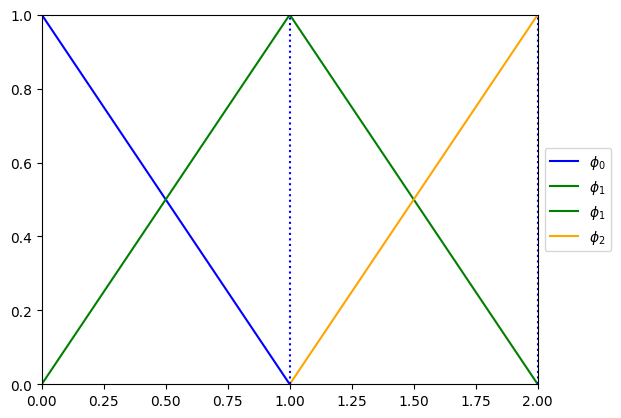

In [3]:
x1 = np.linspace(0, 1, 1000)
x2 = np.linspace(1, 2, 1000)
fig = plt.figure()

plt.plot(x1, 1 - x1, color='blue', label=r'$\phi_0$')
plt.plot(x1, x1, color='green', label=r'$\phi_1$')
plt.plot(x2, 2 - x2, color='green', label=r'$\phi_1$')
plt.plot(x2, x2 - 1, color='orange', label=r'$\phi_2$')

plt.axvline(x=1, color='blue', linestyle=':')
plt.axvline(x=2, color='blue', linestyle=':')

plt.margins(x=0)
plt.margins(y=0)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Program Structure

What we will implement in the code:

- **`def grid(...)`** – Creates the computational grid or mesh used for numerical calculations.  
- **`def assembleMatrix(...)`** – Constructs the stiffness matrix, which represents the system’s coefficients in the finite element formulation.  
- **`def assembleRHS(...)`** – Builds the right-hand side (RHS) vector that incorporates source terms or boundary conditions.  
- **`def linEqsSolver(...)`** – Solves the resulting linear system of equations to obtain the numerical solution.


I.3 Useful Main FEM Frameworks <a name="I.3"></a>
--------------------------------

### Step 1 — Create the grid

Use the `grid(N, ansatz='linear')` function to build the FEM mesh (node coordinates) on [0, 1].

- Parameters  
  - `N` — number of elements (integer)  
  - `ansatz` — `'linear'` (default) or `'quad'` (quadratic)

- Returns: 1D NumPy array of node coordinates.


In [ ]:
def grid(N, ansatz='linear', nonuniform=False):
    """Generate uniform or non-uniform 1D grid."""
    
    node_count = N + 1 if ansatz == 'linear' else 3*N - (N - 1)

    ## each element has 2 nodes for linear ansatz. so the total nodes are N+1. Else is for quadratic ansatz (each element has 3 nodes, but the middle nodes are shared))
    
    vec = np.linspace(0, 1, node_count)
    
    if nonuniform:
        vec = vec**2  # non-uniform mapping
    
    return vec

### Step 2 — Set up the stiffness matrix

The stiffness matrix can directly be computed via
$$
A_{ij} = \int_\Omega \phi'_i(x) \, \phi'_j(x) \, dx \quad
$$
where the basis functions shall be either linear or quadratic ansatz functions. 
- The integrals can be precomputed.
- In regions where the basis functions do not 'overlap', the integral is 0.
- The solution is known on the boundaries. You therefore only need to compute a solution for the unknown inner nodes of the domain. Choose the size of the stiffness matrix correspondingly.

In [ ]:
def assembleMatrix(lattice):
    
    n = len(lattice)
    
    main = np.zeros(n)
    ## main diagonal
    
    upper = np.zeros(n-1)
    ## upper diagonal
    
    for i in range(n-1):
        h = lattice[i+1] - lattice[i]
        main[i] += 1/h
        main[i+1] += 1/h
        upper[i] -= 1/h

    return diags([main, upper, upper], [0, -1, 1], format='csc')

Loops over neighboring nodes `j` for a given node `i`.

In **1D FEM** (Finite Element Method) with **linear basis functions**, each node only interacts with its immediate neighbors:  
`(i-1, i, i+1)`.

Python’s `range` excludes the upper bound, so:

```python
range(i-1, i+2)

### Step 3 — Assemble the right-hand side (RHS)

### Right-Hand Side Computation in FEM

The right-hand side of the equation can be computed as:

$$
b_i(x) = \int_\Omega f(x) \, \phi_i(x) \, dx
$$

#### Notes for Implementation

- For a more general-purpose FEM solver, the function can be defined as:  

```python
def rhs(function, lattice, ansatz='linear'):


In [ ]:
## Right-hand side assembly for f = 1
def rhsConstant(lattice):
    """Assemble right-hand side vector for f = 1."""
    n = len(lattice)
    b = np.zeros(n)
    ## initialize the right-hand side vector
    for i in range(n - 1):
        h = lattice[i + 1] - lattice[i]
        ##compute the element length between nodes i and i+1
        b[i] += h / 2
        ## each element contributes h/2 to both nodes
        b[i + 1] += h / 2
        ## so we add h/2 to both b[i] and b[i+1]
    return b

In [ ]:
def rhsDelta(lattice):
    """RHS vector for delta(x-0.5)."""
    n = len(lattice)
    b = np.zeros(n)
    for i in range(n-1):
        if lattice[i] <= 0.5 <= lattice[i+1]:
            ##Checks if the delta source at x = 0.5 lies inside this element.
            ##Only the element containing x=0.5 gets a non-zero contribution.
            h = lattice[i+1] - lattice[i]
            ##h is the length of the element containing the delta.
            b[i] += 2 * (lattice[i+1] - 0.5)/h
            ##RHS value for the left node of the element.
            b[i+1] += 2 * (0.5 - lattice[i])/h
            ##RHS value for the right node of the element.
    return b


Creates an **N×N** zero matrix, where **N** is the number of nodes.
If `(ansatz == 'linear')`:

Each basis function **Φᵢ(x)** is a piecewise linear "hat" function, nonzero only over two neighboring elements.

So each node **i** only interacts with its neighbors **i−1, i, i+1**.

`grad_Phi` is the derivative of the linear shape function:

$$
\Phi_i(x)
$$

`quad` numerically integrates:

$$
\nabla \Phi_i(x) \cdot \nabla \Phi_j(x)
$$

I.4 Plotting Functions <a name="I.3"></a>
--------------------------------

In [ ]:
def interpolate(x, lattice, u):
    """ Interpolation on piecewise-linear grid."""
    if np.isscalar(x):
        x = np.array([x])
    x = np.clip(x, 0, 1)
    ## ensure x is within the domain [0, 1]

    u_interp = np.zeros_like(x)
    for k, xi in enumerate(x):
        i = np.searchsorted(lattice, xi) - 1
        ## find the element index containing xi
        i = np.clip(i, 0, len(lattice) - 2)
        ## ensure i is within valid range
        h = lattice[i + 1] - lattice[i]
        ## element length
        phi_left = (lattice[i + 1] - xi) / h
        ## linear shape function for left node
        phi_right = (xi - lattice[i]) / h
        ## linear shape function for right node
        u_interp[k] = phi_left * u[i] + phi_right * u[i + 1]
        ## interpolate using shape functions
    return u_interp


In [ ]:
def FEM1DConstant(N):
    """Solve -u'' = 1 with Dirichlet BC u(0)=u(1)=0."""
    G = grid(N)
    A = assembleMatrix(G)
    ## Stiffness matrix
    b = rhsConstant(G)

    # Solve for interior nodes
    u = np.zeros(len(G))
    u_interior = spsolve(A[1:-1, 1:-1], b[1:-1])
    ## Solve the linear system for interior nodes only (excluding boundary nodes)
    u[1:-1] = u_interior
    ## Assign the computed interior values back to the full solution vector

    # Analytical solution
    u_analytical = -0.5 * (G - 0.5) ** 2 + 1 / 8
    return G, u, u_analytical

In [ ]:
def FEM1DDelta(N):
    G = grid(N)
    A = assembleMatrix(G)
    b = rhsDelta(G)
    u = np.zeros(len(G))
    u_interior = spsolve(A[1:-1,1:-1], b[1:-1]) 
    u[1:-1] = u_interior
    u_analytical = np.where(G <= 0.5, 2*G, 2*(1-G))
    #This line defines the analytical solution for the PDE:
    #-u''(x) = 2δ(x - 0.5), u(0) = u(1) = 0
    # G is the vector of FEM nodes (grid points)
    # u_analytical will store the exact solution at each node
    # For x <= 0.5, the solution is u(x) = x
    # For x > 0.5, the solution is u(x) = 1 - x 
    # This creates a piecewise linear function peaking at x=0.5
    return G, u, u_analytical

II. Exercises <a name="II"></a>
=================
### II.1> Exercise 1 <a name="II.1"></a>

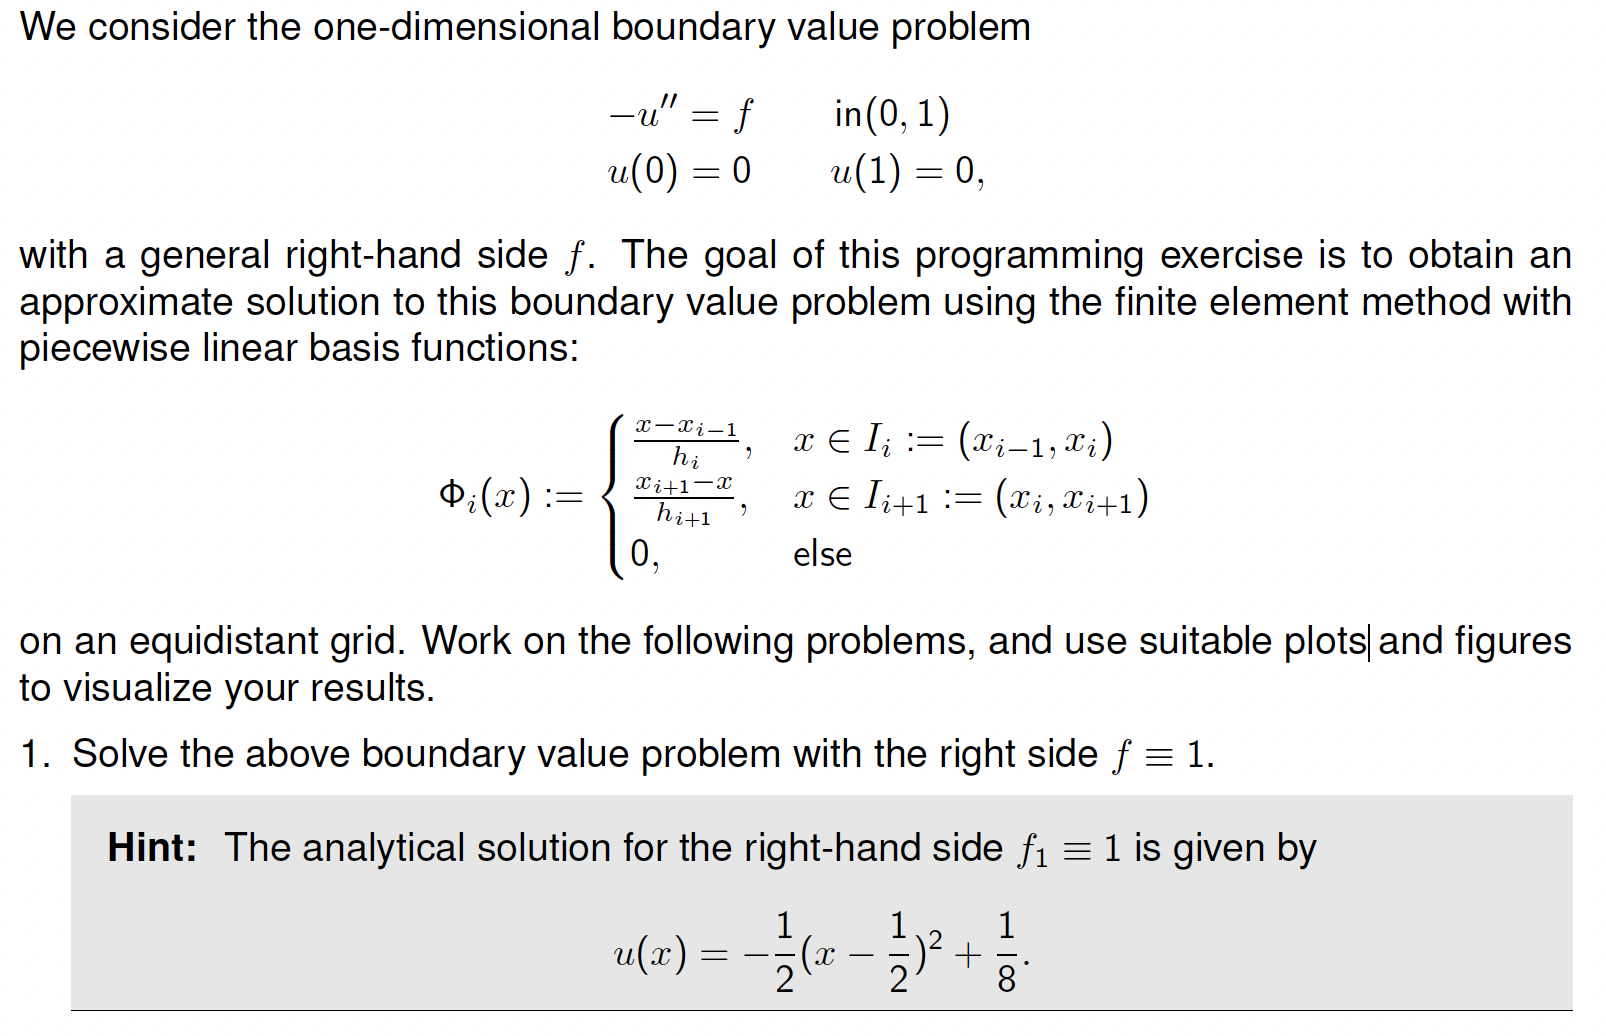

## Motivation how to approach the problem:
To assemble the stiffness matrix for a finite element method (FEM) problem using linear basis functions, we need to consider the contributions of each element to the global stiffness matrix. The matrix is constructed based on the interactions between the basis functions associated with each node in the mesh.
The following code snippet demonstrates how to assemble the stiffness matrix for a 1D FEM problem using linear basis functions:

```python
def assembleMatrix(lattice, ansatz='linear'):
    """
    Assembles the stiffness matrix for the FEM problem.   
    Parameters:
    - lattice: array of node coordinates
    - ansatz: 'linear' or 'quad' for basis function type
    Returns:
    - A: stiffness matrix
    """

How to solve: Numerically solve the equation using your FEM1DConstant function (or any finite element / finite difference method).

Use f(x) = 1 in your RHS vector.

Compare your numerical solution to the analytical solution above. 

## Case 1: $f = 1$ (linear)

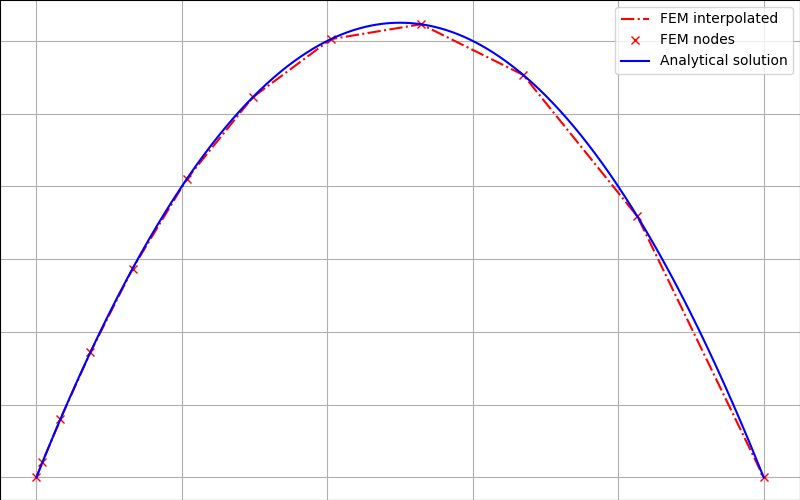

### Accuracy of FEM with Linear Elements for Constant Forcing Functions

Using the **Finite Element Method (FEM)** with **linear elements**, the numerical solution closely matches the analytical solution, particularly at the **nodes**. This behavior is expected when the **source term is constant**, as linear elements can exactly represent the solution between nodes in this case.

- **Node accuracy:** FEM solutions are exact at the nodes for linear elements when dealing with constant source terms.
- **Mesh efficiency:** Even with a **coarse mesh**, the method provides accurate results

### II.2> Exercise 2 <a name="II.2"></a>

Same approach as Exercise 1 but now with a delta function as RHS.

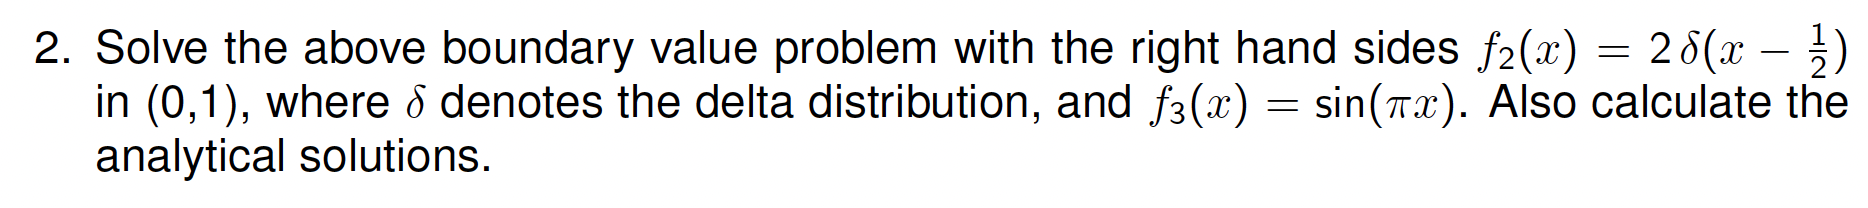

## Case 2: $f(x) = 2\delta(x-1/2)$ (Linear)

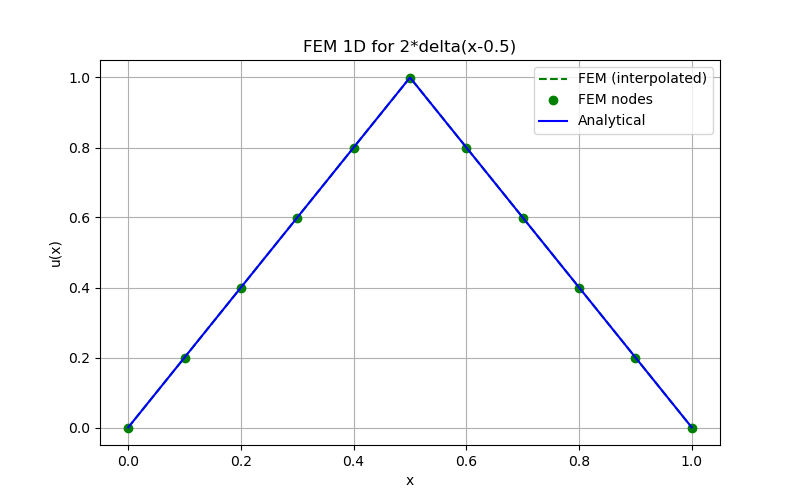

The FEM solution closely follows the analytical solution.

Small differences might appear if the mesh is coarse (`N = 10`), especially near the delta.

Increasing the number of elements (finer grid) makes FEM converge perfectly to the analytical V-shape.


## Case 3: f(x) = $\sin(\pi x)$ (Linear)

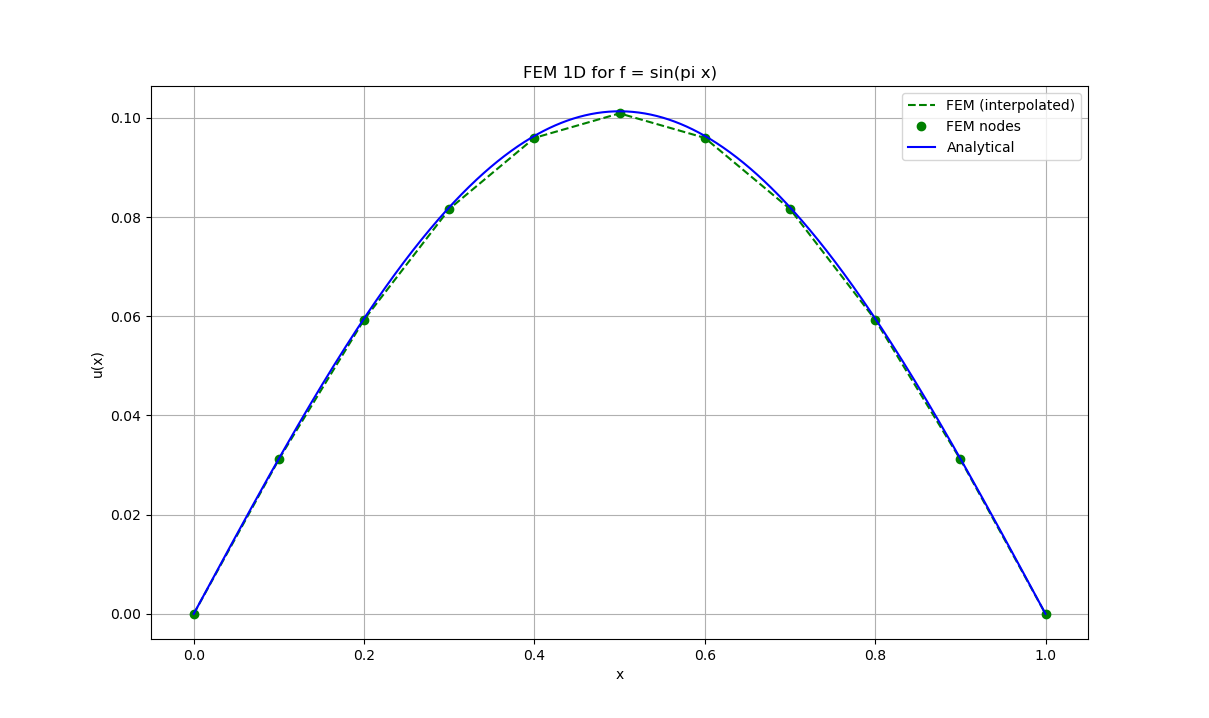

The largest discrepancies appear near the middle of the domain, where the curvature of the sine function is highest

### II.3> Exercise 3 <a name="II.2"></a>

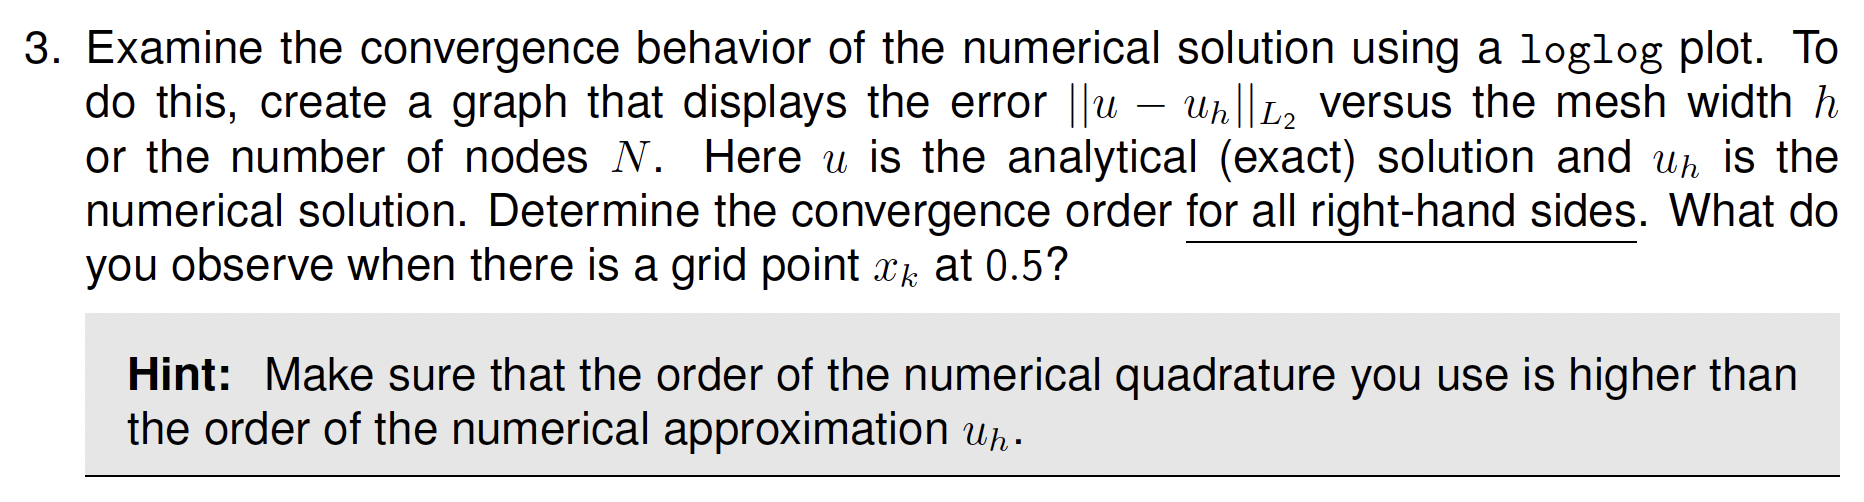

Assume that $error ≈ C⋅h^k$, then $log(error)=logC+klogh$. The slope of the log(error)-log(h) plot is k, i.e. the order of the numerical method. In the above plot, we can observe that in $f=constant$ case, the convergence order is linear, whereas in the case of delta function, it cannot guarantee to converge as the mesh size is getting smaller(more elements). In fact, we can observe that its numerical solution can be precisely approximated when there is a grid point $x_k$ at 0.5 (even number of elements). Therefore, from our above experiments (switching even and odd number of elements), the graph shows that the errors in the delta function case are oscillating and the errors converge (superlinearly) only when the number of elements is even. 

### II.5> Bonus Exercise 5 <a name="II.2"></a>